In [13]:
import pandas as pd
import numpy as np

In [14]:
ap_data = pd.read_excel("all_data_model.xlsx")

In [15]:
ap_data['all_num'].describe()

count    672.000000
mean      13.738095
std       13.010365
min        0.000000
25%        0.000000
50%       13.000000
75%       23.000000
max       78.000000
Name: all_num, dtype: float64

In [16]:
ap_data.set_index(ap_data['date'], inplace=True)

In [17]:
ap_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-09-20 00:00:00 to 2019-10-17 23:00:00
Data columns (total 18 columns):
date              672 non-null datetime64[ns]
all_num           672 non-null int64
temp              672 non-null float64
humid             672 non-null float64
co2               672 non-null float64
voc               672 non-null float64
pm25              672 non-null float64
light             672 non-null float64
noise             672 non-null float64
기온                672 non-null float64
강수량               672 non-null float64
풍속                672 non-null float64
습도                672 non-null int64
date_day          672 non-null int64
date_hour         672 non-null int64
date_weekday      672 non-null int64
model_number_1    672 non-null float64
model_number_2    672 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(5)
memory usage: 99.8 KB


In [18]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

In [22]:
ap_data = ap_data.drop('date',axis = 1)

In [23]:
train = ap_data[:450]
test = ap_data[450:]

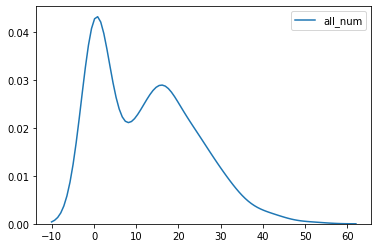

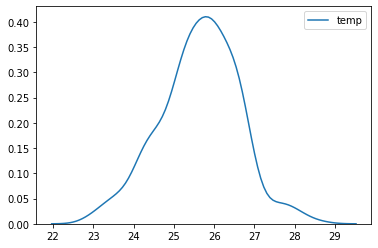

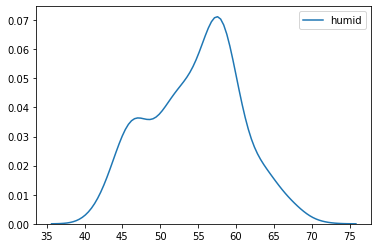

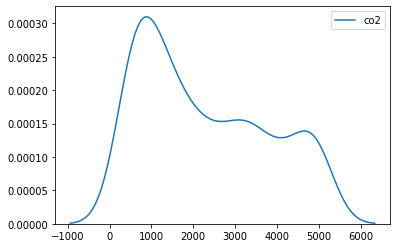

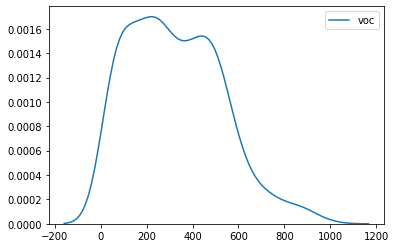

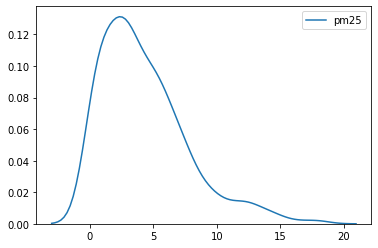

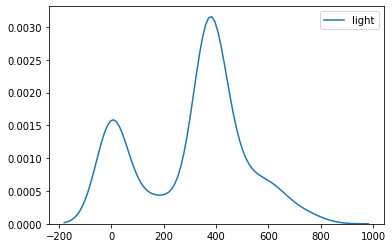

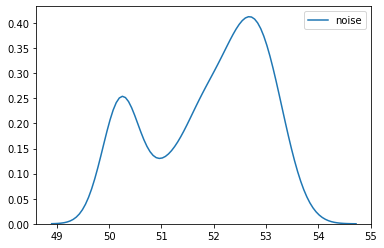

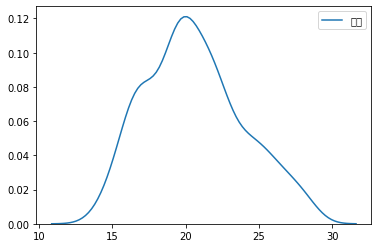

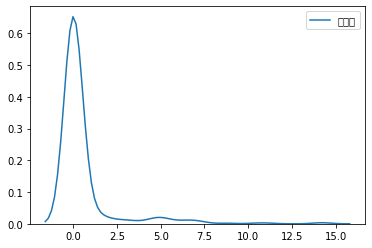

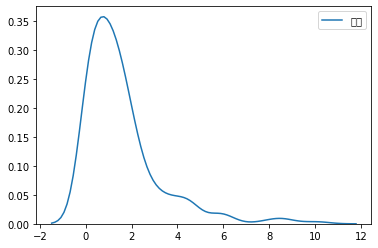

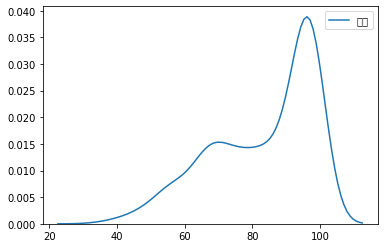

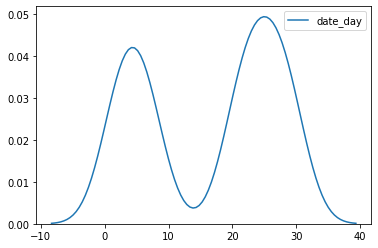

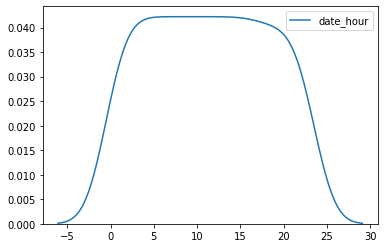

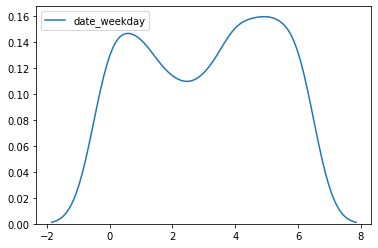

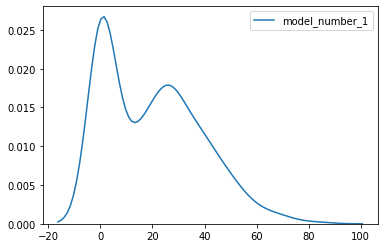

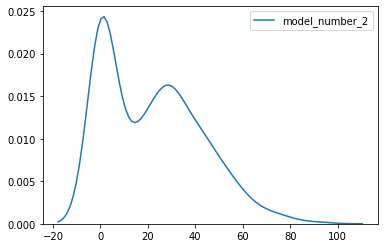

In [24]:
for c in train.columns:
    sns.kdeplot(train[c])
    plt.show()

In [26]:
train_target = train['model_number_1']
train_features = train.drop(['model_number_1'], axis=1)

In [29]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(train_features, train_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [31]:
xgb_params ={
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'silent': [True],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
    'refit' : [True]
}

xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBoostError: [15:31:20] C:/Jenkins/workspace/xgboost-win64_release_0.90/src/tree/updater_gpu_hist.cu:1407: Exception in gpu_hist: [15:31:20] c:\jenkins\workspace\xgboost-win64_release_0.90\src\common\device_helpers.cuh:860: Check failed: device_ordinals.size() == 1 (0 vs. 1) : XGBoost must be compiled with NCCL to use more than one GPU.


In [32]:
lgb_params = {
    'objective':['regression'],
    'num_leave' : [1],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)

LightGBMError: Do not support non-ascii characters in feature name.

In [33]:
xgb_preds = xgb_estimator.predict(df_test)
lgb_preds = lgb_estimator.predict(df_test)
preds = 0.5* xgb_preds + 0.5*lgb_preds

NameError: name 'xgb_estimator' is not defined

In [ ]:
submission=pd.read_csv('../input/sample_submission.csv')
submission['price']=np.exp(preds)
submission.to_csv('xgb_lgb_submission.csv',index=False)1j